## Importamos las librerias que vamos a necesitar en el proyecto

In [89]:
import requests
from dotenv import load_dotenv
import os
import json
from folium import Map, Marker, Icon, FeatureGroup, LayerControl, Choropleth
from folium.plugins import HeatMap
from getpass import getpass
from pymongo import MongoClient
import pandas as pd
import matplotlib.pyplot as plt

In [64]:
client = MongoClient()
db = client.get_database("companies")

In [65]:
client

MongoClient(host=['localhost:27017'], document_class=dict, tz_aware=False, connect=True)

In [66]:
db

Database(MongoClient(host=['localhost:27017'], document_class=dict, tz_aware=False, connect=True), 'companies')

In [67]:
comp = db.companies

### Hacemos un unwinded de la base de datos

In [68]:
res = db.companies.aggregate([
                      {"$unwind":"$offices" },
                      {"$match":{"offices.latitude":{"$ne":None}}},
                      {"$match":{"offices.longitude":{"$ne":None}}},
                      {"$project":{"_id":0}}])

db.companies_unwinded.insert_many(res)

offices = db.companies_unwinded

res = offices.find({},{"offices":1})


for c in res:
    filt = {"_id":c["_id"]}
    coord = {
              "type": "Point",
              "coordinates": [c["offices"]["longitude"], c["offices"]["latitude"]]
            }
    update = {"$set":{"coord":coord}}
    offices.update_one(filt,update)

## Filtrado de la base de datos que disponemos de companies que tienen coordenadas

In [69]:
coord = list(db.companies_unwinded.find({"offices.latitude":{"$ne":None}},{"offices":1,"name":1}))

In [166]:
len(coord)

10834

In [168]:
coord[:2]

[{'_id': ObjectId('5fb2a66656ffd70ef77e3c1f'),
  'name': 'Flektor',
  'offices': {'description': None,
   'address1': '8536 National Blvd, Suite A',
   'address2': None,
   'zip_code': '90232',
   'city': 'Culver City',
   'state_code': 'CA',
   'country_code': 'USA',
   'latitude': 34.025958,
   'longitude': -118.379768}},
 {'_id': ObjectId('5fb2a66656ffd70ef77e3c20'),
  'name': 'AdventNet',
  'offices': {'description': 'Headquarters',
   'address1': '4900 Hopyard Rd.',
   'address2': 'Suite 310',
   'zip_code': '94588',
   'city': 'Pleasanton',
   'state_code': 'CA',
   'country_code': 'USA',
   'latitude': 37.692934,
   'longitude': -121.904945}}]

### Compañias que hayan levantado más de 1 millón de dolares

In [71]:

a=list(db.companies_unwinded.find({"funding_rounds.raised_amount":{"$gt":1000000}}))

In [72]:
len(a)

3212

### Compañías que hayan levantado más de 1 millón de dolares y que tengan localización disponible

In [73]:
b=list(db.companies_unwinded.find({"funding_rounds.raised_amount":{"$gt":1000000},"offices.latitude":{"$ne":None}},{"offices":1,"name":1}))

In [74]:
len(b)

3212

In [75]:
b[0]

{'_id': ObjectId('5fb2a66656ffd70ef77e3c21'),
 'name': 'Geni',
 'offices': {'description': 'Headquarters',
  'address1': '9229 W. Sunset Blvd.',
  'address2': '',
  'zip_code': '90069',
  'city': 'West Hollywood',
  'state_code': 'CA',
  'country_code': 'USA',
  'latitude': 34.090368,
  'longitude': -118.393064}}

### Filtramos por empresas y categorias de empresa para buscar las del tipo design (desarrolladoras: video games)

In [76]:
c=list(db.companies_unwinded.find({"offices.latitude":{"$ne":None}},{"category_code":1,"name":1}))

In [77]:
len(c)

10834

In [137]:
list(c)[:5]

[{'_id': ObjectId('5fb2a66656ffd70ef77e3c1f'),
  'name': 'Flektor',
  'category_code': 'games_video'},
 {'_id': ObjectId('5fb2a66656ffd70ef77e3c20'),
  'name': 'AdventNet',
  'category_code': 'enterprise'},
 {'_id': ObjectId('5fb2a66656ffd70ef77e3c21'),
  'name': 'Geni',
  'category_code': 'web'},
 {'_id': ObjectId('5fb2a66656ffd70ef77e3c22'),
  'name': 'Postini',
  'category_code': 'web'},
 {'_id': ObjectId('5fb2a66656ffd70ef77e3c23'),
  'name': 'Zoho',
  'category_code': 'software'}]

In [138]:
d=[e["category_code"] for e in c]

In [139]:
d

['games_video',
 'enterprise',
 'web',
 'web',
 'software',
 'web',
 'web',
 'web',
 'music',
 'news',
 'web',
 'mobile',
 'games_video',
 'web',
 'games_video',
 'social',
 'news',
 'games_video',
 'news',
 'web',
 'web',
 'social',
 'search',
 'advertising',
 'games_video',
 'social',
 'social',
 'social',
 'web',
 'games_video',
 'web',
 'games_video',
 'web',
 'mobile',
 'advertising',
 'web',
 'web',
 'web',
 'web',
 'web',
 'web',
 'advertising',
 'advertising',
 'advertising',
 'advertising',
 'photo_video',
 'web',
 'security',
 'finance',
 'web',
 'games_video',
 'mobile',
 'games_video',
 'games_video',
 'games_video',
 'games_video',
 'games_video',
 'web',
 'games_video',
 'mobile',
 'software',
 'search',
 'web',
 'web',
 'web',
 'mobile',
 'search',
 'games_video',
 'ecommerce',
 'games_video',
 'web',
 'games_video',
 'mobile',
 'mobile',
 'mobile',
 'web',
 'web',
 'games_video',
 'games_video',
 'games_video',
 'web',
 'games_video',
 'ecommerce',
 'enterprise',
 'mobi

### Sacamos un listado de las categorias de compañías que tiene nuestro listado  companies

In [80]:
# Hacemos el set del listado para no ver valores repetidos.
#de aqui vamos a filtrar en adelante también por la categoria: video_game ya que nuestra compañía es de videogames.
set(d)

{None,
 'advertising',
 'analytics',
 'automotive',
 'biotech',
 'cleantech',
 'consulting',
 'design',
 'ecommerce',
 'education',
 'enterprise',
 'fashion',
 'finance',
 'games_video',
 'hardware',
 'health',
 'hospitality',
 'legal',
 'local',
 'manufacturing',
 'medical',
 'messaging',
 'mobile',
 'music',
 'nanotech',
 'network_hosting',
 'news',
 'nonprofit',
 'other',
 'photo_video',
 'public_relations',
 'real_estate',
 'search',
 'security',
 'semiconductor',
 'social',
 'software',
 'sports',
 'transportation',
 'travel',
 'web'}

In [82]:
# A través de Series de Pandas, vemos qué categorías son las más repetidas dentro de nuestra base de datos Companies
category = []
for comp in c:
    category.append(comp['category_code'])
top_categories=pd.Series(category).value_counts()

In [83]:
top_categories

web                 2307
software            1885
mobile               682
advertising          679
games_video          644
other                625
enterprise           542
consulting           445
ecommerce            412
network_hosting      410
public_relations     357
search               273
hardware             271
biotech              241
cleantech            214
security             108
semiconductor         87
analytics             64
social                50
finance               37
news                  28
music                 26
education             25
medical               22
messaging             22
travel                21
photo_video           19
health                18
manufacturing         15
legal                 14
transportation        10
hospitality            9
real_estate            8
automotive             8
sports                 8
fashion                6
nanotech               5
design                 4
nonprofit              3
local                  1


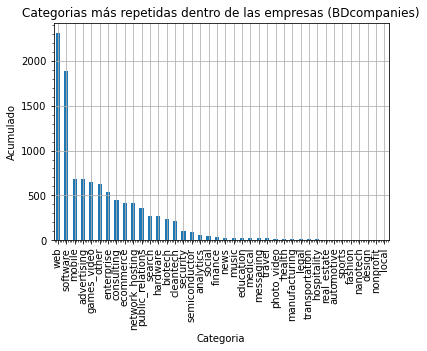

In [92]:
# Lo representamos gráficamente
top_categories.plot(kind="bar")
plt.xlabel('Categoria') 
plt.ylabel('Acumulado') 
plt.title('Categorias más repetidas dentro de las empresas (BDcompanies)') 
plt.minorticks_on() 
plt.grid()

### Lo aplicamos a nuestro analisis (compañías con mas de 1 millón de dólares de fund rasing , con localización activa y  categoria:video_games )

In [84]:
lista_definitiva=list(db.companies_unwinded.find({"funding_rounds.raised_amount":{"$gt":1000000},"offices.latitude":{"$ne":None},"category_code":{"$eq":"games_video"}},{"offices":1,"name":1,"category_code":1}))

In [85]:
# Esta va a ser la lista definitiva sobre la que vamos a trabajar
len(lista_definitiva)

193

In [192]:
lista_definitiva[:1]

[{'_id': ObjectId('5fb2a66656ffd70ef77e3c2b'),
  'name': 'Lala',
  'category_code': 'games_video',
  'offices': {'description': 'Lala Headquarters',
   'address1': '209 Hamilton Ave',
   'address2': 'Suite #200',
   'zip_code': '94301',
   'city': 'Palo Alto',
   'state_code': 'CA',
   'country_code': 'USA',
   'latitude': 37.451151,
   'longitude': -122.154369}}]

In [178]:
j=[e["offices"] for e in lista_definitiva]

In [187]:
#Sacamos las ciudades que más se repiten
i=[e["city"] for e in j]
i[:5]

['Palo Alto', 'New York', 'London', 'San Francisco', 'San Diego']

In [186]:
len(i)

193

In [190]:
cities=[]
for ciudad in j:
    cities.append(ciudad["city"])
top_cities= pd.Series(cities).value_counts()

In [191]:
top_cities

San Francisco    27
New York         21
Los Angeles       7
Seattle           6
Santa Monica      6
                 ..
Boulder           1
Burlingame        1
Vancouver         1
Tel Aviv          1
Berlin            1
Length: 82, dtype: int64

### Tras analizas las compañías por localización, decidimos ubicarnos en San Francisco, ya que es donde más empresas de design existen y que hayan levantado más de 1 millón de dólares de fund rasing

## Probamos con la localización de las oficinas de Hi5 ( San Francisco)

In [87]:
# a continuación mostramos el category_code, la dirección, y las coordenadas
lista_definitiva[18]

{'_id': ObjectId('5fb2a66956ffd70ef77e3ce7'),
 'name': 'hi5',
 'category_code': 'games_video',
 'offices': {'description': '',
  'address1': '55 Second Street',
  'address2': 'Suite 400',
  'zip_code': '94105',
  'city': 'San Francisco',
  'state_code': 'CA',
  'country_code': 'USA',
  'latitude': 37.788668,
  'longitude': -122.400558}}

### Utilización de Apis - Token

In [107]:
# Cargamos nuestro token
load_dotenv()

True

In [108]:
# importamos nuestros tokens encriptados de .gitignore (.env)
token_google = os.getenv("key")
fq_client_id=os.getenv("fsquare_id") 
fq_client_secret=os.getenv("fsquare_secret")

# Miramos las peticiones de los desarroladores:

### Empresas de diseño que estén cerca de la oficina:

In [204]:
# $near
# https://docs.mongodb.com/manual/reference/operator/query/near/

point = {"type":"Point",
         "coordinates":[-122.400558,37.788668 ]}

query ={
    "coord":{
        "$near":{
            "$geometry":point,
            "$maxDistance":500,
            #"$minDistance":
        }
    }
}

res = offices.find(query,{"offices":1,"name":1})

In [205]:
list(res)[:5]

[{'_id': ObjectId('5fb2a66956ffd70ef77e3ce7'),
  'name': 'hi5',
  'offices': {'description': '',
   'address1': '55 Second Street',
   'address2': 'Suite 400',
   'zip_code': '94105',
   'city': 'San Francisco',
   'state_code': 'CA',
   'country_code': 'USA',
   'latitude': 37.788668,
   'longitude': -122.400558}},
 {'_id': ObjectId('5fb2a66956ffd70ef77e4799'),
  'name': 'TRUSTe',
  'offices': {'description': '',
   'address1': '835 Market Street',
   'address2': 'Suite 800',
   'zip_code': '94103',
   'city': 'San Francisco',
   'state_code': 'CA',
   'country_code': 'USA',
   'latitude': 37.7886685,
   'longitude': -122.4005576}},
 {'_id': ObjectId('5fb2a66b56ffd70ef77e60bf'),
  'name': 'Marketcetera',
  'offices': {'description': 'San Francisco',
   'address1': '28 2nd Street',
   'address2': '3rd Floor',
   'zip_code': '94105',
   'city': 'San Francisco',
   'state_code': 'CA',
   'country_code': 'USA',
   'latitude': 37.788864,
   'longitude': -122.4008487}},
 {'_id': ObjectId('5

In [197]:
# sacamos el listado de nombres de empresas de desarrollo de video_games 
#que están ubicadas a 500m de la localización de nuestra empresa.
names=[e["name"] for e in res]
names[:10]

['hi5',
 'TRUSTe',
 'Marketcetera',
 'Danoo',
 'Creative Commons',
 'Involver',
 'Jobspring Partners',
 'Calypso Technology',
 'Adknowledge',
 'AdParlor',
 'SquareTrade',
 'NorthStar Systems International',
 'Huddler',
 'Serious Business',
 'Farallon Geographics',
 'KickApps',
 'Macroaxis',
 'Twilio',
 'AMP Consulting',
 'Genbook',
 'Lyft',
 'Lyft',
 'Roost',
 'McKesson Surgical Solutions',
 'Spleak',
 'Innotas',
 'Innotas',
 'MacArthur Associates',
 'Workbridge Associates',
 'HubPages',
 'NaturalPath Media',
 'YieldBuild',
 'Eightfold Logic',
 'Lolapps',
 'Decorati',
 'Lolapps',
 'Curse',
 'Jobvite',
 'NaturalMotion',
 'Playboox',
 'Kongregate',
 'Simply Continuous',
 'Sportgenic',
 'eXelate',
 'GottaPark',
 'Prosper',
 'Premier Staffing',
 '5th Finger',
 'Grassroots',
 'PlayFirst',
 'Aruspex',
 'Viator',
 'Keibi Technologies',
 'Exent',
 'Stylehive',
 'CITTIO',
 'Rapleaf',
 'GreenVolts',
 'AddictingGames',
 'Atom Entertainment',
 'kwiry',
 'TerraPass',
 'Granicus',
 'Fat Goose',
 'Zi

In [202]:
#Sabemos que hay 150 empresas a 500 m de distancia
len(list(res))

150

### Starbucks cerca de la oficina:

In [349]:
#utilizamos la api de foursquare, ponemos las coordenadas de nuestras 
#oficinas y buscamos una query con los starbucks mas cercanos:
url = 'https://api.foursquare.com/v2/venues/explore'

params = dict(
client_id=fq_client_id,
client_secret=fq_client_secret,
v='20201015',
ll='37.788668,-122.400558',
query='starbucks',
limit=15
)
resp = requests.get(url=url, params=params)
starbucks = json.loads(resp.text)

In [355]:
starbucks[:3]

{'meta': {'code': 200, 'requestId': '5fb175be4450ba020e3f3bb5'},
 'response': {'suggestedFilters': {'header': 'Tap to show:',
   'filters': [{'name': '$-$$$$', 'key': 'price'},
    {'name': 'Open now', 'key': 'openNow'}]},
  'suggestedRadius': 600,
  'headerLocation': 'Financial District',
  'headerFullLocation': 'Financial District, San Francisco',
  'headerLocationGranularity': 'neighborhood',
  'query': 'starbucks',
  'totalResults': 50,
  'suggestedBounds': {'ne': {'lat': 37.79325477483147,
    'lng': -122.39289941269296},
   'sw': {'lat': 37.7837092564839, 'lng': -122.40919233344827}},
  'groups': [{'type': 'Recommended Places',
    'name': 'recommended',
    'items': [{'reasons': {'count': 0,
       'items': [{'summary': 'This spot is popular',
         'type': 'general',
         'reasonName': 'globalInteractionReason'}]},
      'venue': {'id': '5c788e57da2e00002c1f200f',
       'name': 'Starbucks',
       'location': {'address': '415 Mission St Fl 5',
        'crossStreet': 'at

In [368]:
dist_tech=starbucks["response"]["groups"][0]["items"][1]
dist_tech

{'reasons': {'count': 0,
  'items': [{'summary': 'This spot is popular',
    'type': 'general',
    'reasonName': 'globalInteractionReason'}]},
 'venue': {'id': '541857f5498ea01d9508334f',
  'name': 'Starbucks',
  'location': {'address': '100 Montgomery',
   'crossStreet': 'at Sutter St',
   'lat': 37.790069965335256,
   'lng': -122.40208260905273,
   'labeledLatLngs': [{'label': 'display',
     'lat': 37.790069965335256,
     'lng': -122.40208260905273}],
   'distance': 205,
   'postalCode': '94104',
   'cc': 'US',
   'city': 'San Francisco',
   'state': 'CA',
   'country': 'United States',
   'formattedAddress': ['100 Montgomery (at Sutter St)',
    'San Francisco, CA 94104',
    'United States']},
  'categories': [{'id': '4bf58dd8d48988d1e0931735',
    'name': 'Coffee Shop',
    'pluralName': 'Coffee Shops',
    'shortName': 'Coffee Shop',
    'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/coffeeshop_',
     'suffix': '.png'},
    'primary': True}],
  'photos': {'co

In [417]:
# tenemon un starbucks a 205 m de la oficina
dist_tech=starbucks["response"]["groups"][0]["items"][1]["venue"]["location"]["distance"]


print(f"distancia de nuestras oficinas: {dist_tech}m")

distancia de nuestras oficinas: 205m


### Miramos si hay un aeropuerto cerca

In [369]:
#utilizamos la api de foursquare, ponemos las coordenadas de nuestras 
#oficinas y buscamos si hay un aeropuerto cercano:
url = 'https://api.foursquare.com/v2/venues/explore'

params = dict(
client_id=fq_client_id,
client_secret=fq_client_secret,
v='20201015',
ll='37.788668,-122.400558',
query='Airport',
limit=15
)
resp = requests.get(url=url, params=params)
airport = json.loads(resp.text)

In [370]:
airport[:2]

{'meta': {'code': 200, 'requestId': '5fb17a56c699df34c88b2d19'},
 'response': {'suggestedFilters': {'header': 'Tap to show:',
   'filters': [{'name': 'Open now', 'key': 'openNow'}]},
  'suggestedRadius': 600,
  'headerLocation': 'Financial District',
  'headerFullLocation': 'Financial District, San Francisco',
  'headerLocationGranularity': 'neighborhood',
  'query': 'airport',
  'totalResults': 55,
  'suggestedBounds': {'ne': {'lat': 37.80176184999501,
    'lng': -122.38617842271924},
   'sw': {'lat': 37.60790115010469, 'lng': -122.40633207187057}},
  'groups': [{'type': 'Recommended Places',
    'name': 'recommended',
    'items': [{'reasons': {'count': 0,
       'items': [{'summary': 'This spot is popular',
         'type': 'general',
         'reasonName': 'globalInteractionReason'}]},
      'venue': {'id': '41059b00f964a520850b1fe3',
       'name': 'San Francisco International Airport (SFO) (San Francisco International Airport)',
       'location': {'address': 'N McDonnell Rd',
  

In [405]:
dist_airp=airport["response"]["groups"][0]["items"][0]["venue"]["location"]["distance"]

In [481]:
#vemos que tenemos un aeropuesto ( San Francisco International Airport ) a 19178 m lo que equivale a 12,7 millas y a 15 minutos conduciendo
print(f"distancia de nuestras oficinas: {dist_airp}m")

distancia de nuestras oficinas: 19178m


### Miramos si hay guarderias / colegios

In [409]:
#utilizamos la api de foursquare, ponemos las coordenadas de nuestras 
#oficinas y buscamos si hay un colegio/guardería cercano:
url = 'https://api.foursquare.com/v2/venues/explore'

params = dict(
client_id=fq_client_id,
client_secret=fq_client_secret,
v='20201015',
ll='37.788668,-122.400558',
query='School',
limit=15
)
resp = requests.get(url=url, params=params)
school = json.loads(resp.text)

In [410]:
school[:3]

{'meta': {'code': 200, 'requestId': '5fb1816ed91d7d1d498e9019'},
 'response': {'suggestedFilters': {'header': 'Tap to show:',
   'filters': [{'name': 'Open now', 'key': 'openNow'}]},
  'suggestedRadius': 600,
  'headerLocation': 'Financial District',
  'headerFullLocation': 'Financial District, San Francisco',
  'headerLocationGranularity': 'neighborhood',
  'query': 'school',
  'totalResults': 139,
  'suggestedBounds': {'ne': {'lat': 37.792379307983396,
    'lng': -122.3961093001709},
   'sw': {'lat': 37.7763095567627, 'lng': -122.40755003332521}},
  'groups': [{'type': 'Recommended Places',
    'name': 'recommended',
    'items': [{'reasons': {'count': 0,
       'items': [{'summary': 'This spot is popular',
         'type': 'general',
         'reasonName': 'globalInteractionReason'}]},
      'venue': {'id': '4f5f9d66e4b0b97ed9cc318a',
       'name': 'EC San Francisco',
       'location': {'address': '100 Montgomery St',
        'lat': 37.7900971088512,
        'lng': -122.4018337853

In [411]:
dist_school=school["response"]["groups"][0]["items"][0]["venue"]["location"]["distance"]

In [482]:
# encontramos la escuela EC San Francisco a sólo 194 m de nuestras oficinas
dist_school
print(f"distancia de nuestras oficinas: {dist_school}m")

distancia de nuestras oficinas: 194m


### Miramos sitios de fiesta cerca de la oficina, ya que la media de la gente es de 25-40 años

In [39]:
url = 'https://api.foursquare.com/v2/venues/explore'

params = dict(
client_id=fq_client_id,
client_secret=fq_client_secret,
v='20201015',
ll='37.788668,-122.400558',
query='Country Dance Club',
limit=15
)
resp = requests.get(url=url, params=params)
dance = json.loads(resp.text)

In [40]:
dance

{'meta': {'code': 200, 'requestId': '5fb271f9556f332995e56011'},
 'response': {'warning': {'text': 'There aren\'t a lot of results for "Country Dance Club." Try something more general, reset your filters, or expand the search area.'},
  'suggestedRadius': 1800,
  'headerLocation': 'Financial District',
  'headerFullLocation': 'Financial District, San Francisco',
  'headerLocationGranularity': 'neighborhood',
  'query': 'country dance club',
  'totalResults': 2,
  'suggestedBounds': {'ne': {'lat': 37.798257339050295,
    'lng': -122.40258976174316},
   'sw': {'lat': 37.756625879943854, 'lng': -122.41440900339354}},
  'groups': [{'type': 'Recommended Places',
    'name': 'recommended',
    'items': [{'reasons': {'count': 0,
       'items': [{'summary': 'This spot is popular',
         'type': 'general',
         'reasonName': 'globalInteractionReason'}]},
      'venue': {'id': '55b126b8498e9a95dca7806e',
       'name': 'Bathroom (unisex) at Swissnex SFO',
       'location': {'lat': 37.79

In [47]:
# encontramos la discoteca, Country Dance Club

In [44]:
dist_dance=dance["response"]["groups"][0]["items"][1]["venue"]["location"]["distance"]

In [46]:
dist_dance
print(f"distancia de nuestras oficinas: {dist_dance}m")

distancia de nuestras oficinas: 3554m


### Miramos sitios de entretenimiento cerca de la oficina, como puede ser un museo

In [35]:
url = 'https://api.foursquare.com/v2/venues/explore'

params = dict(
client_id=fq_client_id,
client_secret=fq_client_secret,
v='20201015',
ll='37.788668,-122.400558',
query='Museum',
limit=15
)
resp = requests.get(url=url, params=params)
museum = json.loads(resp.text)

In [1]:
museum[:3]

NameError: name 'museum' is not defined

In [37]:
dist_museum=museum["response"]["groups"][0]["items"][0]["venue"]["location"]["distance"]

In [38]:
# encontramos el museo SFMOMA a sólo 259 m de nuestras oficinas
dist_museum
print(f"distancia de nuestras oficinas: {dist_museum}m")

distancia de nuestras oficinas: 259m


### Pintamos graficamente nuestra empresa en el mapa con los deseos de los desarrolladores: Starbucks , colegio y sitios de fiesta

In [88]:
oficina = [37.788668,-122.400558]

#Crear mapa
mapa = folium.Map(location = oficina, zoom_start = 17)
office = Marker(location=[37.788668, -122.400558], tooltip="oficina", popup="nuevas oficinas!")
starbks= Marker(location=[37.790069965335256, -122.40208260905273], tooltip="starbucks", popup="cafe recien hecho!")
airpor= Marker(location=[37.6167130000997, -122.38709449768066], tooltip="aeropuerto", popup="listos para despegar!")
coles= Marker(location=[37.7900971088512, -122.40183378539855], tooltip="colegio", popup="chicos, a clase!")
muse= Marker(location=[37.7863356901678, -122.4004037044823], tooltip="museo", popup="inspiración!")
muse.add_to(mapa)
coles.add_to(mapa)
airpor.add_to(mapa)
office.add_to(mapa)
starbks.add_to(mapa)
mapa

### Lo representamos en una escala más grande para que se vea donde está nuestra oficina con respecto al aeropuerto

In [462]:
oficina = [37.788668,-122.400558]

#Crear mapa
mapa = folium.Map(location = oficina, zoom_start = 10)
office = Marker(location=[37.788668, -122.400558], tooltip="oficina", popup="nuevas oficinas!")
starbks= Marker(location=[37.790069965335256, -122.40208260905273], tooltip="starbucks", popup="cafe recien hecho!")
airpor= Marker(location=[37.6167130000997, -122.38709449768066], tooltip="aeropuerto", popup="listos para despegar!")
coles= Marker(location=[37.7900971088512, -122.40183378539855], tooltip="colegio", popup="chicos, a clase!")
coles.add_to(mapa)
airpor.add_to(mapa)
office.add_to(mapa)
starbks.add_to(mapa)
mapa